In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# for getting summary info on models
from torchsummary import summary

import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [4]:
nGauss = 1000
imgSize = 91
x = np.linspace(-4, 4, imgSize)
X, Y = np.meshgrid(x,x)

# vary the weights smoothly
widths = np.linspace(2, 20, nGauss)

# initialize tensor containing images
images = torch.zeros(nGauss, 1, imgSize, imgSize)

for i in range(nGauss):

    # create the gaussian with random centers
    ro = np.random.randn(2) # random offset
    G = np.exp(-((X-ro[0])**2+(Y-ro[1])**2)/widths[i])

    # and add noise
    G = G + np.random.randn(imgSize, imgSize)/5

    # add a random bar randomly
    i1 = np.random.choice(np.arange(2, 28))
    i2 = np.random.choice(np.arange(2, 6))

    if np.random.randn()>0:
        G[i1:i1+i2, ] = 1
    else:
        G[:, i1:i1+i2] = 1

    images[i, :, :, :] = torch.Tensor(G).view(1, imgSize, imgSize)



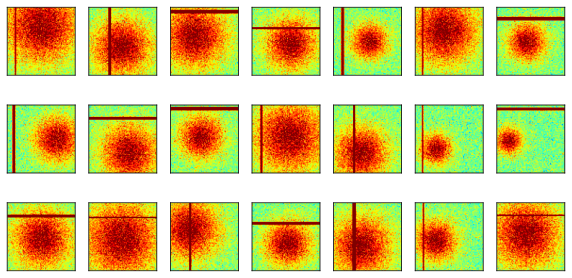

In [15]:
fig, axs = plt.subplots(3, 7, figsize = (10, 5))

for i, ax in enumerate(axs.flatten()):
    whichpic = np.random.randint(nGauss)
    G = np.squeeze(images[whichpic,:,:,:])
    ax.imshow(G, vmin = -1, vmax = 1, cmap = 'jet')
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

In [18]:
# create a class for the model

def makeTheNet():

    class gausnet(nn.Module):
        def __init__(self):
            super().__init__()

            self.enc = nn.Sequential(
                nn.Conv2d(1, 6, 3, padding = 1),
                nn.ReLU(),
                nn.MaxPool2d(2,2),
                nn.Conv2d(6, 4, 3, padding = 1),
                nn.ReLU(),
                nn.MaxPool2d(2,2)
            )
            self.dec = nn.Sequential(
                nn.ConvTranspose2d(4, 6, 3, 2),
                nn.ReLU(),
                nn.ConvTranspose2d(6, 1, 3, 2)
            )

        def forward(self, x):
            return self.dec(self.enc(x))


    net = gausnet()
    lossfun = nn.MSELoss()

    optimizer = torch.optim.Adam(net.parameters(), lr = .001)
    return net, lossfun, optimizer

 
torch.Size([10, 1, 91, 91])


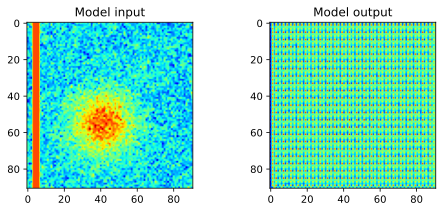

In [22]:
net, lossfun, optimizer = makeTheNet()

yHat = net(images[:10, :, :, :])

# check size of output

print(' ')
print(yHat.shape)

fig, ax = plt.subplots(1, 2, figsize = (8, 3))

ax[0].imshow(torch.squeeze(images[0,:,:,:]).detach(), cmap = 'jet')
ax[0].set_title('Model input')
ax[1].imshow(torch.squeeze(yHat[0,:,:,:]).detach(), cmap = 'jet')
ax[1].set_title('Model output')
plt.show()

In [23]:
summary(net, (1, imgSize, imgSize))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 91, 91]              60
              ReLU-2            [-1, 6, 91, 91]               0
         MaxPool2d-3            [-1, 6, 45, 45]               0
            Conv2d-4            [-1, 4, 45, 45]             220
              ReLU-5            [-1, 4, 45, 45]               0
         MaxPool2d-6            [-1, 4, 22, 22]               0
   ConvTranspose2d-7            [-1, 6, 45, 45]             222
              ReLU-8            [-1, 6, 45, 45]               0
   ConvTranspose2d-9            [-1, 1, 91, 91]              55
Total params: 557
Trainable params: 557
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 1.24
Params size (MB): 0.00
Estimated Total Size (MB): 1.27
---------------------------------------------------

In [28]:
def function2trainTheModel():

    # number of epochs
    numepochs = 500

    # create a new model
    net, lossfun, optimizer = makeTheNet()

    # initialize the losses
    losses = torch.zeros(numepochs)

    for epochi in range(numepochs):

        # pick a set of images at random
        pics2use = np.random.choice(nGauss, size = 32, replace = False)
        X = images[pics2use, :,:,:]
        # forward pass and loss
        yHat = net(X)
        loss = lossfun(yHat, X)
        losses[epochi] = loss.item()

        # back prop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return losses, net


In [29]:
losses, net = function2trainTheModel()


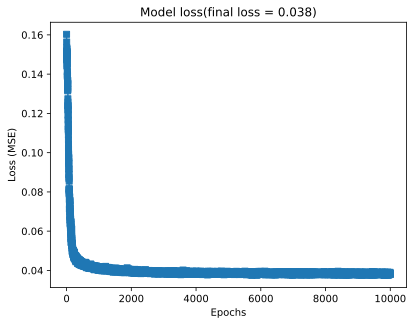

In [30]:
plt.plot(losses, 's-', label = 'Train')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Model loss(final loss = %.3f)' %losses[-1])

plt.show()

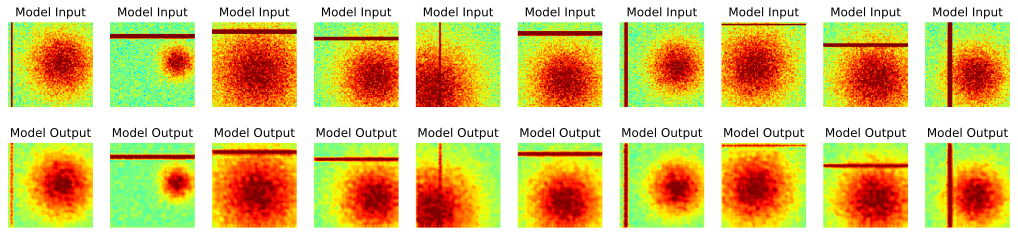

In [31]:
# visualize some images
pics2use = np.random.choice(nGauss, size = 32, replace = False)
X = images[pics2use, :, :]
yHat = net(X)

fig, axs = plt.subplots(2, 10, figsize = (18, 4))

for i in range(10):

    G = torch.squeeze(X[i, 0, :, :]).detach()
    O = torch.squeeze(yHat[i, 0, :, :]).detach()

    axs[0, i].imshow(G, vmin = -1, vmax = 1, cmap = 'jet')
    axs[0, i].axis('off')
    axs[0, i].set_title('Model Input')

    axs[1, i].imshow(O, vmin = -1, vmax = 1, cmap = 'jet')
    axs[1, i].axis('off')
    axs[1, i].set_title('Model Output')

plt.show()